### Importing Libraries

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.DatabaseConnection import DatabaseConnection
from dotenv import find_dotenv
import matplotlib.colors as clr

colors = ['#c79242', '#c7a842', '#42c792', '#42c7a8', '#4242c7', '#a842c7']
cmap = clr.ListedColormap(colors)

plt.style.use("bmh")

### Connecting to the Database

In [76]:
dotenv_path = find_dotenv()
connection = DatabaseConnection(dotenv_path)

#### Clustering by in-game statistics per minute

In [77]:
# Extracting the data from the database
query = """SELECT p.vision_score_per_min, p.dmg_per_min, p.gold_per_min,
           p.cs_per_min, p.rank, p.lane
           FROM player_data AS p WHERE p.rank!='UNRANKED';"""

data = connection.execute_select_query(query)
data = pd.DataFrame(data)

In [78]:
data

vision_score_per_min  dmg_per_min  gold_per_min  cs_per_min      rank  \
0                 0.597045     1141.230       561.158    5.892640      GOLD   
1                 0.867568      856.914       382.257    5.606360  PLATINUM   
2                 0.723974      896.355       461.591    6.595630   EMERALD   
3                 0.585110      565.066       381.371    6.696580  PLATINUM   
4                 0.483216      884.050       488.324    7.066740   DIAMOND   
...                    ...          ...           ...         ...       ...   
6500              0.452939      543.915       345.699    7.604510    SILVER   
6501              0.278843      425.287       323.802    5.733240    SILVER   
6502              0.518375      491.616       339.883    5.653620    SILVER   
6503              0.697508      485.014       386.423    0.358328    SILVER   
6504              0.590818      389.597       318.469    0.836098    SILVER   

     lane  
0     BOT  
1     TOP  
2     TOP  
3     TOP  
4     BOT  
...   ...  
6500  MID  
6501  TOP  
6502  BOT  
6503  JNG  
6504  JNG  

[6505 rows x 6 columns]

According to my internal knowledge of the game, I am going to find clusters based by lane

In [79]:
data

vision_score_per_min  dmg_per_min  gold_per_min  cs_per_min      rank  \
0                 0.597045     1141.230       561.158    5.892640      GOLD   
1                 0.867568      856.914       382.257    5.606360  PLATINUM   
2                 0.723974      896.355       461.591    6.595630   EMERALD   
3                 0.585110      565.066       381.371    6.696580  PLATINUM   
4                 0.483216      884.050       488.324    7.066740   DIAMOND   
...                    ...          ...           ...         ...       ...   
6500              0.452939      543.915       345.699    7.604510    SILVER   
6501              0.278843      425.287       323.802    5.733240    SILVER   
6502              0.518375      491.616       339.883    5.653620    SILVER   
6503              0.697508      485.014       386.423    0.358328    SILVER   
6504              0.590818      389.597       318.469    0.836098    SILVER   

     lane  
0     BOT  
1     TOP  
2     TOP  
3     TOP  
4     BOT  
...   ...  
6500  MID  
6501  TOP  
6502  BOT  
6503  JNG  
6504  JNG  

[6505 rows x 6 columns]

In [80]:
data.isna().sum()

vision_score_per_min    0
dmg_per_min             0
gold_per_min            0
cs_per_min              0
rank                    0
lane                    0
dtype: int64

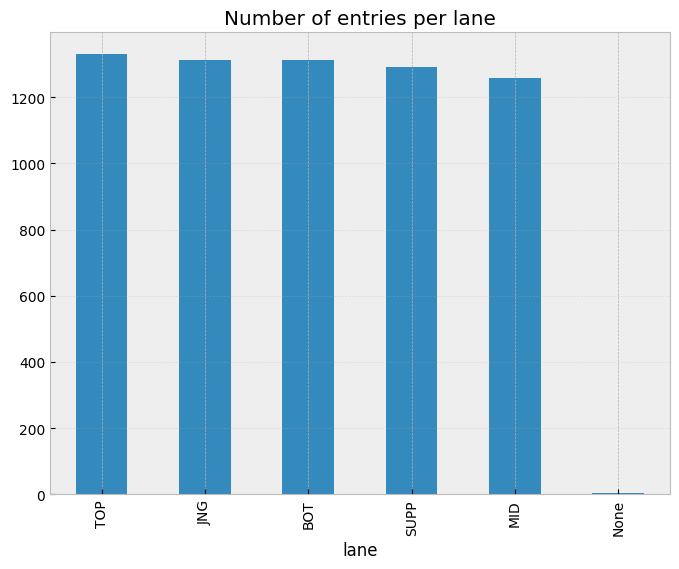

In [81]:
ax = data.value_counts('lane').plot(kind='bar', title='Number of entries per lane', figsize=(8,6))
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()

The distribtion of lanes is balanced, as expected - in each game there is two players for each lane.

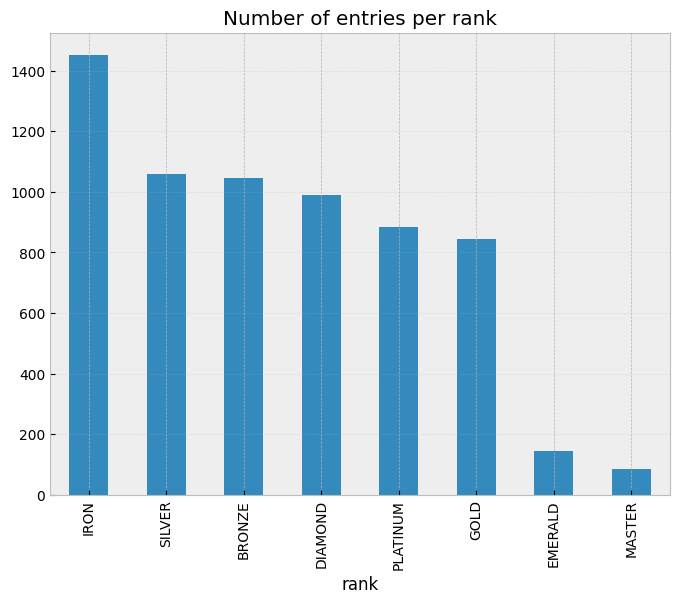

In [82]:
ax = data.value_counts('rank').plot(kind='bar', title='Number of entries per rank', figsize=(8,6))
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()

Most of the entries are from the IRON rank, which is the lowest rank in the game. A lot of people getting new accounts start from there.

In [83]:
# some of the entries have lane as 'None' which is not a valid lane, so I will drop them
# also, I will drop the entries with rank as 'EMERALD' and 'MASTER' since there is not enough entries for this analysis
data = data[(data['lane'] != 'None') & ~(data['rank'].isin(["EMERALD", "MASTER"]))]

In [84]:
lane_groups = data.groupby('lane')

In [85]:
lane_groups.size()

lane
BOT     1270
JNG     1267
MID     1218
SUPP    1253
TOP     1266
dtype: int64

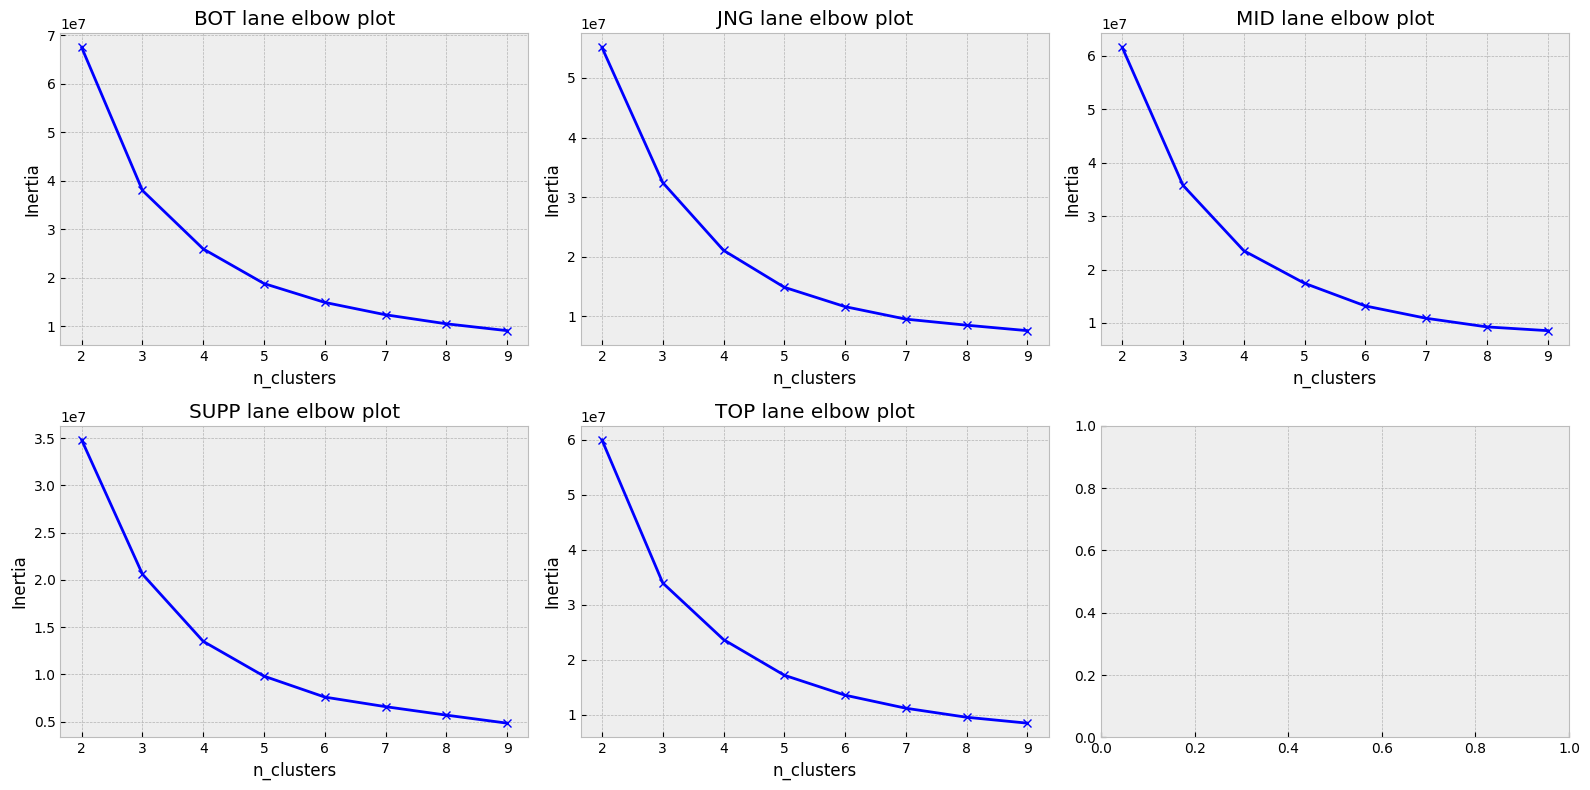

In [86]:
from sklearn.cluster import KMeans

fig, ax = plt.subplots(2, 3, figsize=(16,8))
for i, (lane, group) in enumerate(lane_groups):
    player_data = group.iloc[:, 0:4].values
    ranks = group.iloc[:, 4].values
    distortions = []
    K_el = range(2,10)
    for k_el in K_el:
        model = KMeans(n_clusters=k_el)
        model.fit(player_data)
        distortions.append(model.inertia_)
    ax[i//3, i%3].plot(K_el, distortions, 'bx-')
    ax[i//3, i%3].set_title(f'{lane} lane elbow plot')
    ax[i//3, i%3].set_xlabel('n_clusters')
    ax[i//3, i%3].set_ylabel('Inertia')

plt.tight_layout()
plt.show()

Three clusters seem to be the optimal number of clusters for all lanes. Let's fit the model with 3 clusters.

In [87]:
results = []
clustered_groups = []

for n, (lane, group) in enumerate(lane_groups):
    
    player_data = group.iloc[:, 0:4].values
    ranks = group.iloc[:, 4].values
    model = KMeans(n_clusters=3)
    model.fit(player_data)
    labels = model.labels_

    labels_divisions = pd.DataFrame(np.concatenate((ranks.reshape(-1,1), labels.reshape(-1,1)), axis=1), columns=['Rank', 'Cluster'])
    subset = labels_divisions.groupby(['Rank', 'Cluster']).size().reset_index(name='Counts')
    group['Cluster'] = labels
    clustered_groups.append((lane, group))
    results.append((lane, subset))


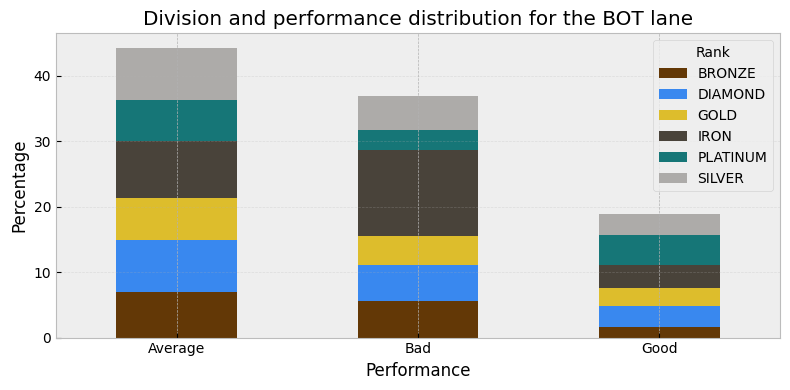

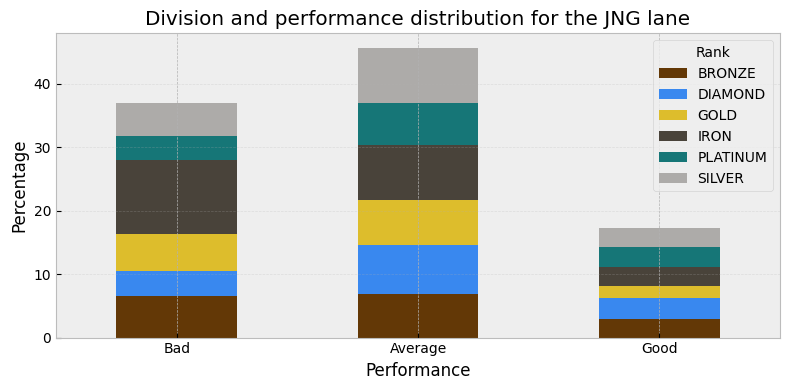

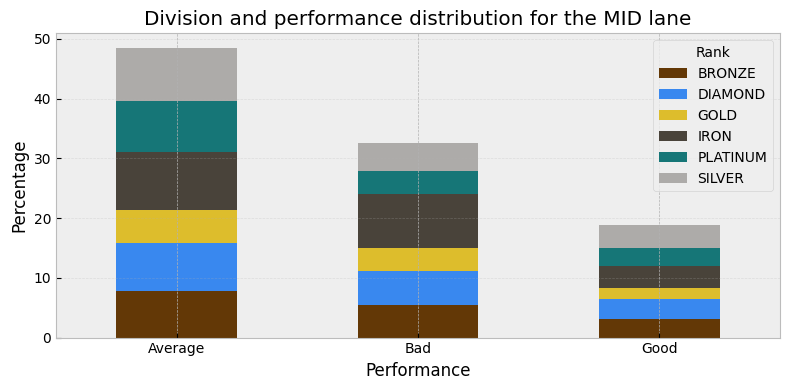

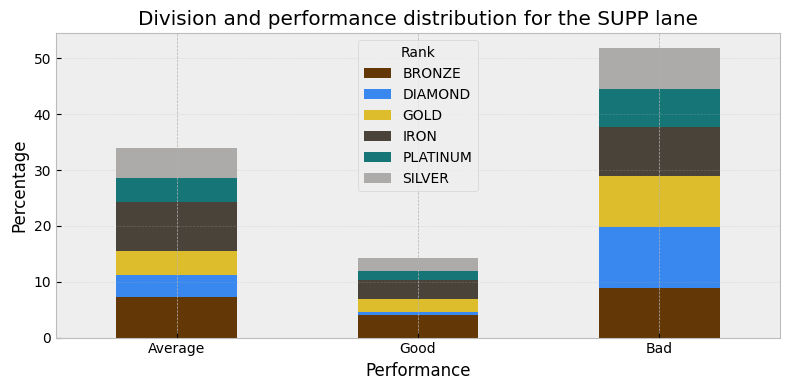

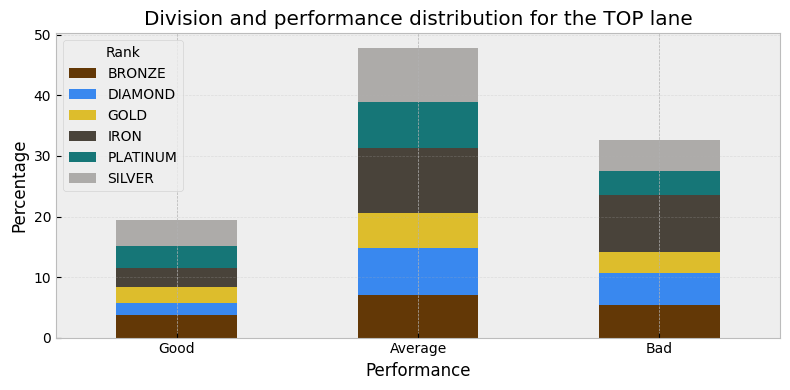

In [88]:
# lets look at the average values for each cluster
cluster_mappings = dict()
performance_groups = ["Good", "Average", "Bad"]
colors = ['#49433a', '#633806', '#adaba9', '#ddbd2c', '#167677', '#3988ef']
divisions = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND']

color_dict = dict(zip(divisions, colors))

for lane, group in clustered_groups:
    by_cluster_means = group.groupby('Cluster').mean(numeric_only=True)
    by_cluster_means["Total"] = by_cluster_means.sum(axis=1)
    sorted_clusters = by_cluster_means.sort_values(by='Total', ascending=False)
    cluster_mappings[lane] = sorted(list(zip(sorted_clusters.index, performance_groups)), key=lambda x: x[0])


for lane, subset in results:
    total_entries = subset['Counts'].sum()
    subset['Percentage'] = subset.apply(lambda x: (x['Counts']/total_entries)*100, axis=1)
    pivot_table = subset.pivot(index='Cluster', columns='Rank', values='Percentage')
    ax = pivot_table.plot(kind='bar', stacked=True, color=color_dict, title=f'Division and performance distribution for the {lane} lane', figsize=(8,4))
    cluster_mapping = cluster_mappings[lane]
    cluster_label = [performance for _, performance in cluster_mapping]
    ax.set_xticklabels(cluster_label, rotation=0)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_xlabel('Performance')
    ax.set_ylabel('Percentage')
    plt.tight_layout()
    plt.show()

#### Conclusions:
JNG and SUPP are the hardest lanes to perform well in, as there is significantly more bad performances in these lanes.
Division does not seem to differ a lot between the clusters.

#### Champions clustering

In [89]:
query = """SELECT c.champion_name, p.vision_score_per_min, p.dmg_per_min, p.gold_per_min,
           p.cs_per_min, p.kills, p.deaths, p.assists, p.dmg_taken_per_min, p.lane
           FROM player_data AS p LEFT JOIN champions as c ON c.champion_id=p.champion_id;"""

data = connection.execute_select_query(query)
data = pd.DataFrame(data)
data = data[data['lane'] != 'None']

data

champion_name  vision_score_per_min  dmg_per_min  gold_per_min  \
0          Karthus              0.753319     1956.870       523.637   
1           Rammus              0.507208      702.903       388.191   
2       Blitzcrank              2.859450      445.768       299.992   
3            Vayne              1.021830     1547.190       557.786   
4            Leona              1.986760      624.430       283.096   
...            ...                   ...          ...           ...   
9025  Aurelion Sol              0.452939      543.915       345.699   
9026       Camille              0.278843      425.287       323.802   
9027          Jhin              0.518375      491.616       339.883   
9028         Briar              0.697508      485.014       386.423   
9029            Vi              0.590818      389.597       318.469   

      cs_per_min  kills  deaths  assists  dmg_taken_per_min  lane  
0       1.049700     22      12       11           1350.890   JNG  
1       0.381710      7      13       40           1400.950   JNG  
2       0.715706      4      10       33           1064.800  SUPP  
3       5.320080     24       8       13           1287.510   TOP  
4       0.954274      3      13       31           1232.830  SUPP  
...          ...    ...     ...      ...                ...   ...  
9025    7.604510      1       6        4            804.088   MID  
9026    5.733240      2       5        3           1074.780   TOP  
9027    5.653620      4       6        2            701.088   BOT  
9028    0.358328      4       1        9           1331.750   JNG  
9029    0.836098      3       6        5           1119.890   JNG  

[9022 rows x 10 columns]

In [90]:
data.isna().sum()

champion_name           0
vision_score_per_min    0
dmg_per_min             0
gold_per_min            0
cs_per_min              0
kills                   0
deaths                  0
assists                 0
dmg_taken_per_min       0
lane                    0
dtype: int64

In [91]:
champion_roles = data.groupby("champion_name")["lane"].value_counts(ascending=False)
champion_roles = pd.DataFrame(champion_roles.reset_index())

most_occurrences = []
for champion in champion_roles["champion_name"].unique():
    occurences_in_roles = champion_roles[champion_roles["champion_name"] == champion]
    most_popular_role = occurences_in_roles[occurences_in_roles["count"] == max(occurences_in_roles["count"])]
    most_occurrences.append((most_popular_role.iloc[0]["champion_name"], most_popular_role.iloc[0]["lane"]))
    
most_occurrences = pd.DataFrame(most_occurrences, columns=["champion_name", "lane"])
most_occurrences

champion_name  lane
0          Aatrox   TOP
1            Ahri   MID
2           Akali   MID
3          Akshan   MID
4         Alistar  SUPP
..            ...   ...
162          Zeri   BOT
163         Ziggs  SUPP
164        Zilean  SUPP
165           Zoe   MID
166          Zyra  SUPP

[167 rows x 2 columns]

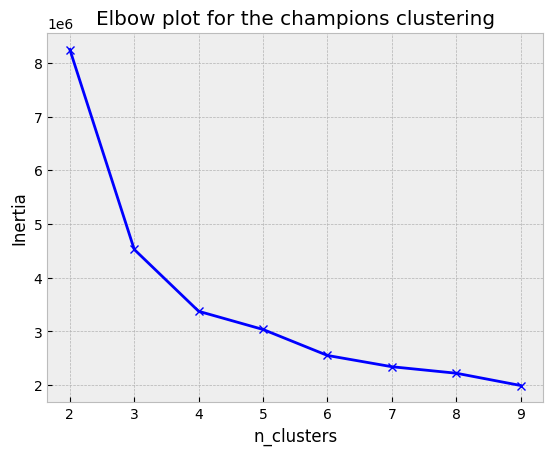

In [92]:
from sklearn.cluster import KMeans

clustering_columns = ['vision_score_per_min', 'dmg_per_min', 'gold_per_min', 'cs_per_min', 'dmg_taken_per_min', 'kills', 'deaths', 'assists']
target = "champion_name"
champion_groups = data.groupby(target).mean(numeric_only=True)
champion_groups.reset_index()
champion_groups = champion_groups.merge(most_occurrences, on="champion_name")
distortions = []

K_el = range(2,10)
for k_el in K_el:
    model = KMeans(n_clusters=k_el)
    X = champion_groups.loc[:, clustering_columns]
    model.fit(X)
    distortions.append(model.inertia_)

plt.title('Elbow plot for the champions clustering')
plt.xlabel('n_clusters')
plt.ylabel('Inertia')
plt.plot(K_el, distortions, 'bx-')
plt.show()

Based on the elbow plot above, I will choose 4 clusters for the champions clustering.

In [93]:
N_CLUSTERS = 4
model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
X = champion_groups.loc[:, clustering_columns]
model.fit(X)
champion_groups['Cluster'] = model.labels_

In [94]:
champion_groups

champion_name  vision_score_per_min  dmg_per_min  gold_per_min  \
0          Aatrox              0.535538   776.400971    396.085114   
1            Ahri              0.610168   750.312324    382.404234   
2           Akali              0.541789   726.840653    386.834178   
3          Akshan              0.532507   849.867811    444.887818   
4         Alistar              2.032016   267.804013    277.570957   
..            ...                   ...          ...           ...   
162          Zeri              0.565055   728.345780    433.603976   
163         Ziggs              0.926662   948.337850    412.263650   
164        Zilean              1.628579   376.155692    284.267692   
165           Zoe              0.885896   733.452643    379.690643   
166          Zyra              1.745109   680.382432    319.797473   

     cs_per_min     kills    deaths    assists  dmg_taken_per_min  lane  \
0      6.228301  6.057143  5.628571   4.600000        1107.513371   TOP   
1      5.833740  6.233645  5.943925   7.803738         740.049754   MID   
2      5.303308  8.118812  5.603960   4.485149         873.753111   MID   
3      6.196258  9.000000  5.363636   4.431818         738.329132   MID   
4      0.773879  1.695652  6.304348  14.130435         875.701696  SUPP   
..          ...       ...       ...        ...                ...   ...   
162    6.619450  7.609756  5.853659   6.341463         748.985220   BOT   
163    5.069716  6.550000  6.350000   7.850000         629.450750  SUPP   
164    1.309906  2.000000  6.461538  11.923077         815.650231  SUPP   
165    4.761599  6.500000  4.428571   7.357143         570.724429   MID   
166    2.109552  3.810811  6.027027   9.945946         601.329851  SUPP   

     Cluster  
0          1  
1          0  
2          0  
3          0  
4          2  
..       ...  
162        0  
163        0  
164        2  
165        0  
166        0  

[167 rows x 11 columns]

In [95]:
champ_cluster = champion_groups[["champion_name", "Cluster"]].values
champ_cluster = {pair[0] : pair[1] for pair in champ_cluster}

data["Cluster"] = data["champion_name"].infer_objects(copy=False).replace(champ_cluster)
data

/var/folders/p5/5h0hmqdn3qn_zqtvdbyg_nfm0000gn/T/ipykernel_4229/1294137901.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Cluster"] = data["champion_name"].infer_objects(copy=False).replace(champ_cluster)


champion_name  vision_score_per_min  dmg_per_min  gold_per_min  \
0          Karthus              0.753319     1956.870       523.637   
1           Rammus              0.507208      702.903       388.191   
2       Blitzcrank              2.859450      445.768       299.992   
3            Vayne              1.021830     1547.190       557.786   
4            Leona              1.986760      624.430       283.096   
...            ...                   ...          ...           ...   
9025  Aurelion Sol              0.452939      543.915       345.699   
9026       Camille              0.278843      425.287       323.802   
9027          Jhin              0.518375      491.616       339.883   
9028         Briar              0.697508      485.014       386.423   
9029            Vi              0.590818      389.597       318.469   

      cs_per_min  kills  deaths  assists  dmg_taken_per_min  lane  Cluster  
0       1.049700     22      12       11           1350.890   JNG        1  
1       0.381710      7      13       40           1400.950   JNG        1  
2       0.715706      4      10       33           1064.800  SUPP        2  
3       5.320080     24       8       13           1287.510   TOP        0  
4       0.954274      3      13       31           1232.830  SUPP        2  
...          ...    ...     ...      ...                ...   ...      ...  
9025    7.604510      1       6        4            804.088   MID        0  
9026    5.733240      2       5        3           1074.780   TOP        1  
9027    5.653620      4       6        2            701.088   BOT        0  
9028    0.358328      4       1        9           1331.750   JNG        3  
9029    0.836098      3       6        5           1119.890   JNG        1  

[9022 rows x 11 columns]

What are the most popular champions in each cluster? And what defines the clusters?

In [96]:
def make_radar_chart(name, stats, attribute_labels, ax, i):
    labels = np.array(attribute_labels + [attribute_labels[0]])
    angles = np.linspace(0, 2*np.pi, len(labels)-1, endpoint=False)
    stats = np.concatenate((stats,[stats[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    
    ax.plot(angles, stats, 'o-', linewidth=2, label=f"Cluster {i}")
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title(name)
    ax.grid(True)


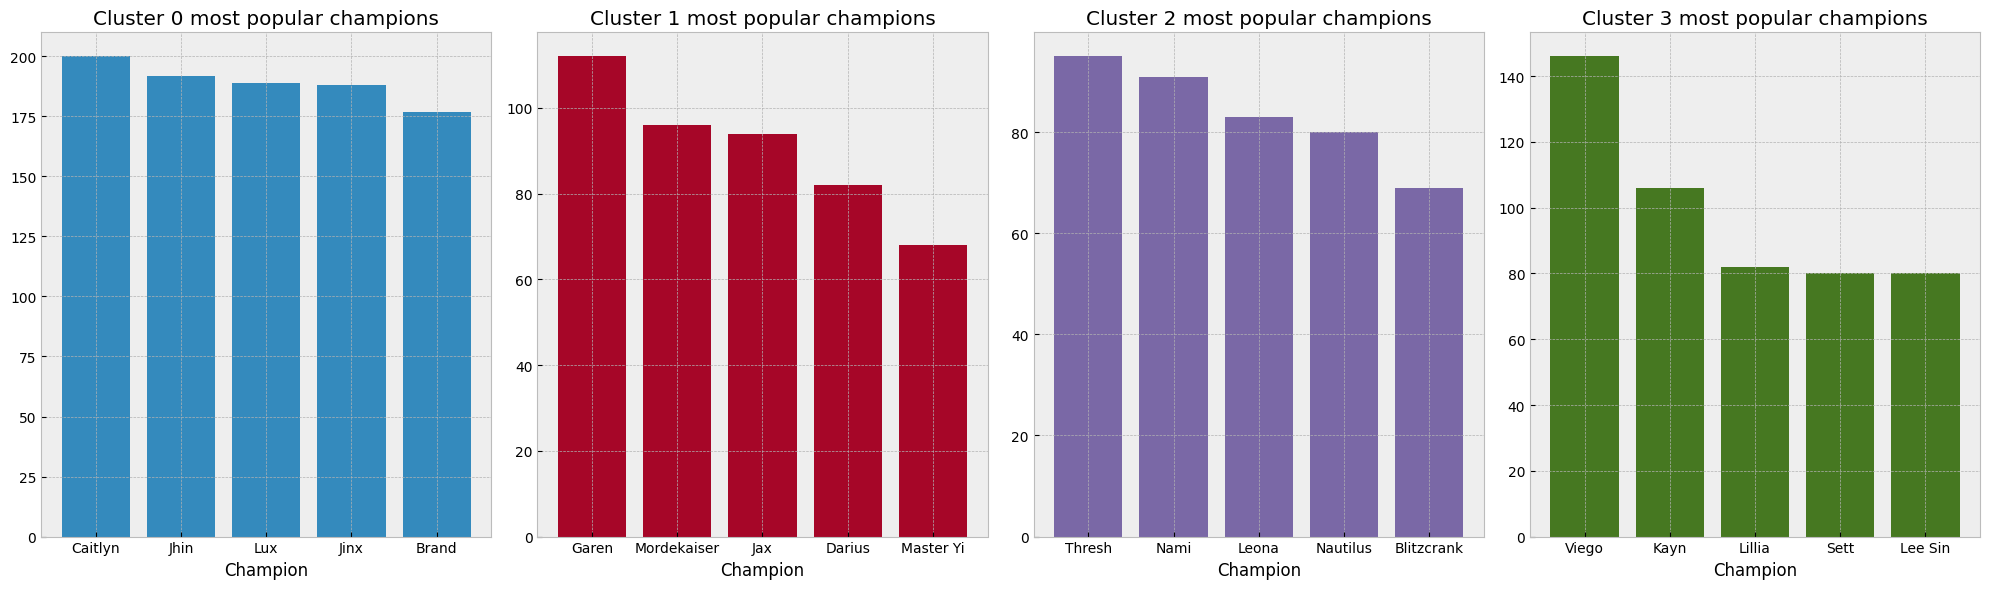

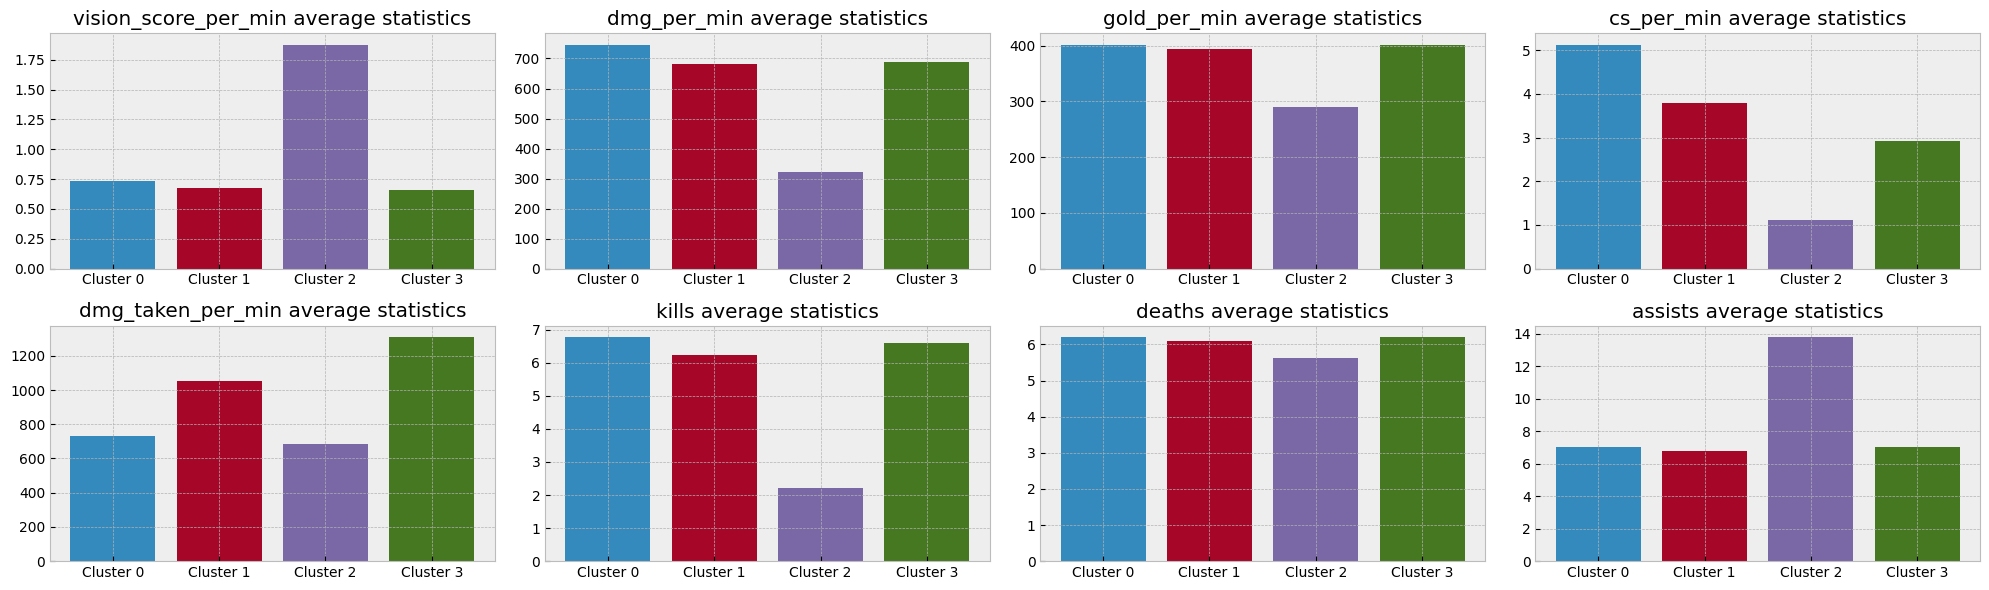

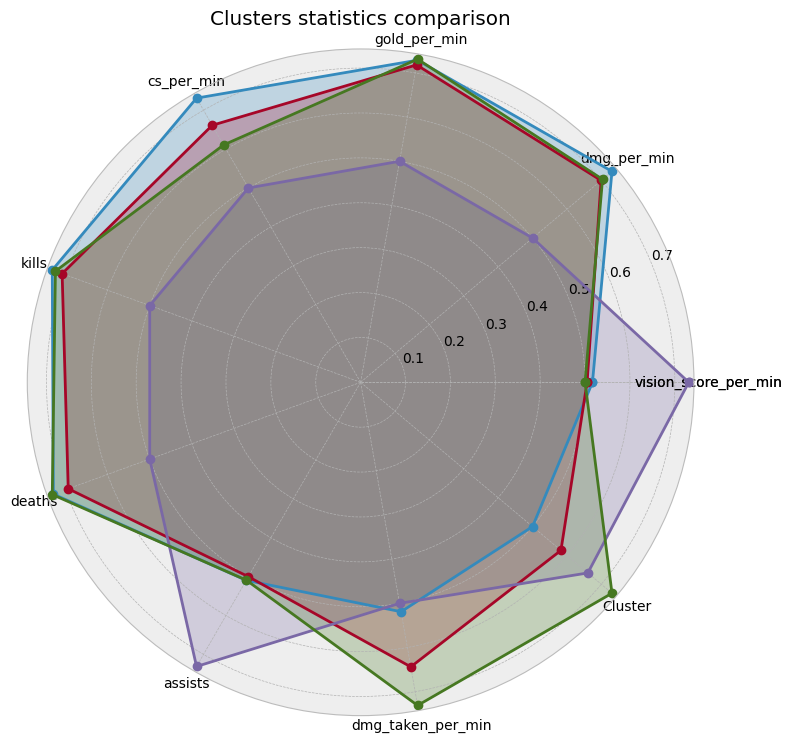

In [97]:
from itertools import cycle
import matplotlib

colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']

champion_groups_clusters = data.groupby('Cluster')
fig, ax = plt.subplots(1, N_CLUSTERS, figsize=(20,6))
group_means = champion_groups_clusters.mean(numeric_only=True)
cluster_means = []
color_cycle = cycle(colors)


for i, (cluster, group) in enumerate(champion_groups_clusters):
    popular_champions = group['champion_name'].value_counts().head(5)
    ax[i].bar(popular_champions.index, popular_champions.values, color=next(color_cycle))
    ax[i].set_title(f'Cluster {cluster} most popular champions')
    ax[i].set_xlabel('Champion')
    cluster_means.append(group.mean(numeric_only=True))
    
plt.tight_layout()
plt.show()
 
n_columns = len(clustering_columns) // 2
fig, ax = plt.subplots(2, n_columns, figsize=(20,6))
   
for i, column in enumerate(clustering_columns):
    column_data = []
    for cluster in cluster_means:
        column_data.append(cluster[column])
    ax[i // n_columns , i % n_columns].bar([f"Cluster {i}" for i in range(N_CLUSTERS)], column_data, color=colors)
    ax[i // n_columns, i % n_columns].set_title(f'{column} average statistics')
    
plt.tight_layout()
plt.show()
    
cluster_means = pd.DataFrame(cluster_means)
cluster_means = cluster_means.apply(lambda x: (x - cluster_means.min()) / (cluster_means.max() - cluster_means.min()), axis=1)
cluster_means = cluster_means.apply(lambda x: 1 / (1 + np.exp(-x)), axis=1)
   
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, polar=True)
labels = list(cluster_means.columns)
for _, row in cluster_means.iterrows():
    make_radar_chart("Clusters statistics comparison", row.values, labels, ax, _)
    
plt.tight_layout()
plt.show()

#### Conclusions:
- Cluster 0 - Melee champions, bruisers
- Cluster 1 - Most damage taken, frontline bruisers / tanks
- Cluster 2 - Supports
- Cluster 3 - Offensive champions (Marksmen and high damage mages) 


Let's now try to cluster champions within the same lane

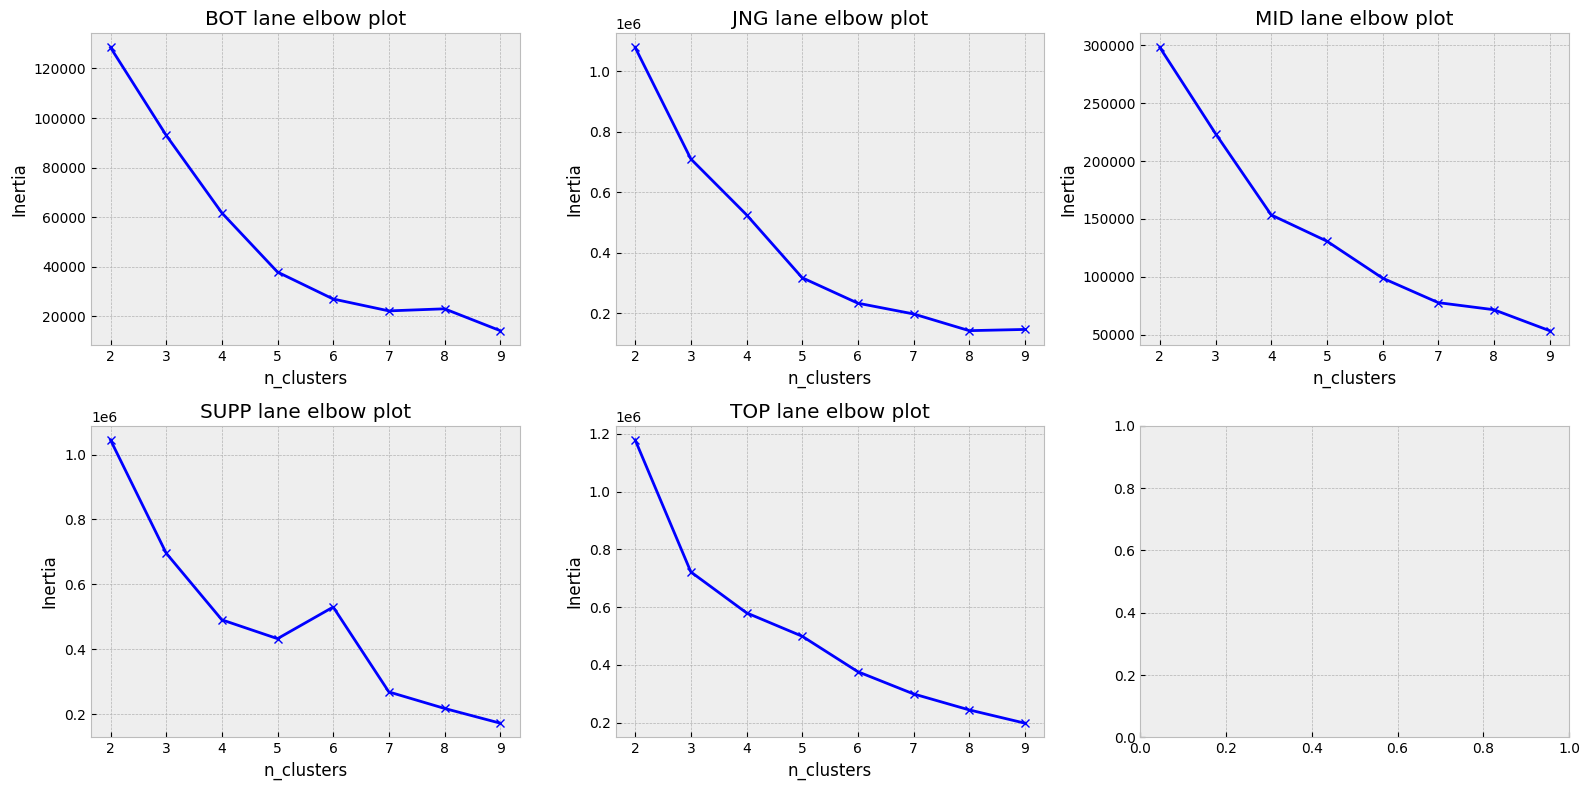

In [98]:
lane_champ_groups = champion_groups.groupby('lane')

clustering_columns = ['vision_score_per_min', 'dmg_per_min', 'gold_per_min', 'cs_per_min', 'dmg_taken_per_min']
distortions = []

fig, ax = plt.subplots(2, 3, figsize=(16,8))
for i, (lane, group) in enumerate(lane_champ_groups):
    player_data = group.loc[:, clustering_columns].values
    distortions = []
    K_el = range(2,10)
    for k_el in K_el:
        model = KMeans(n_clusters=k_el)
        model.fit(player_data)
        distortions.append(model.inertia_)
    ax[i//3, i%3].plot(K_el, distortions, 'bx-')
    ax[i//3, i%3].set_title(f'{lane} lane elbow plot')
    ax[i//3, i%3].set_xlabel('n_clusters')
    ax[i//3, i%3].set_ylabel('Inertia')

plt.tight_layout()
plt.show()

#### Based on the elbow plot above, the number of clusters for each lane is:
- Top lane - 5 clusters
- Jungle lane - 4 clusters
- Support lane 4 clusters
- Middle lane - 4 clusters
- Bottom lane - 3 clusters

In [99]:
from sklearn.preprocessing import MinMaxScaler

def plot_clusters_by_lane(lane, n_clusters, df, champion_groups):
    data = df[df['lane'] == lane].copy()
    
    clustering_columns = ['vision_score_per_min', 'dmg_per_min', 'gold_per_min', 'cs_per_min', 'dmg_taken_per_min', 'kills', 'deaths', 'assists']
    champion_groups_lane = champion_groups[champion_groups["lane"] == lane].copy()
    model = KMeans(n_clusters=n_clusters, random_state=42)
    X = champion_groups_lane.loc[:, clustering_columns]
    model.fit(X)
    champion_groups_lane["Cluster"] = model.labels_
    
    champ_cluster = champion_groups_lane[["champion_name", "Cluster"]].values
    champ_cluster = {pair[0] : pair[1] for pair in champ_cluster}
    
    data["Cluster"] = data["champion_name"].replace(champ_cluster)
    # removing nonstandard laners from the data
    data = data[data["Cluster"].isin(champion_groups_lane["Cluster"].unique())]
    
    fig, ax = plt.subplots(1, n_clusters, figsize=(20,8))
    cluster_means = []

    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']
    color_cycle = cycle(colors)
    champion_groups_clusters = data.groupby('Cluster')

    for i, (cluster, group) in enumerate(champion_groups_clusters):
        popular_champions = group['champion_name'].value_counts().head(5)
        ax[i].bar(popular_champions.index, popular_champions.values, color=next(color_cycle))
        ax[i].set_title(f'Cluster {cluster} most popular champions')
        ax[i].set_xticks(ticks=ax[i].get_xticks())
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)

        ax[i].set_xlabel('Champion')
        cluster_means.append(group.mean(numeric_only=True))

    plt.tight_layout()
    plt.show()

    n_columns = len(clustering_columns) // 2
    fig, ax = plt.subplots(2, n_columns, figsize=(20,6))

    for i, column in enumerate(clustering_columns):
        column_data = []
        for cluster in cluster_means:
            column_data.append(cluster[column])
        ax[i // n_columns , i % n_columns].bar([f"Cluster {i}" for i in range(n_clusters)], column_data, color=colors)
        ax[i // n_columns, i % n_columns].set_title(f'{column} average statistics')

    # stack cluster means
    cluster_means = pd.DataFrame(cluster_means)
    cluster_means = cluster_means.apply(lambda x: (x - cluster_means.min()) / (cluster_means.max() - cluster_means.min()), axis=1)
    cluster_means = cluster_means.apply(lambda x: 1 / (1 + np.exp(-x)), axis=1)

    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, polar=True)
    labels = list(cluster_means.columns)
    for _, row in cluster_means.iterrows():
        make_radar_chart("Clusters statistics comparison", row.values, labels, ax, _)
        
    plt.legend()
    plt.tight_layout()
    plt.show()

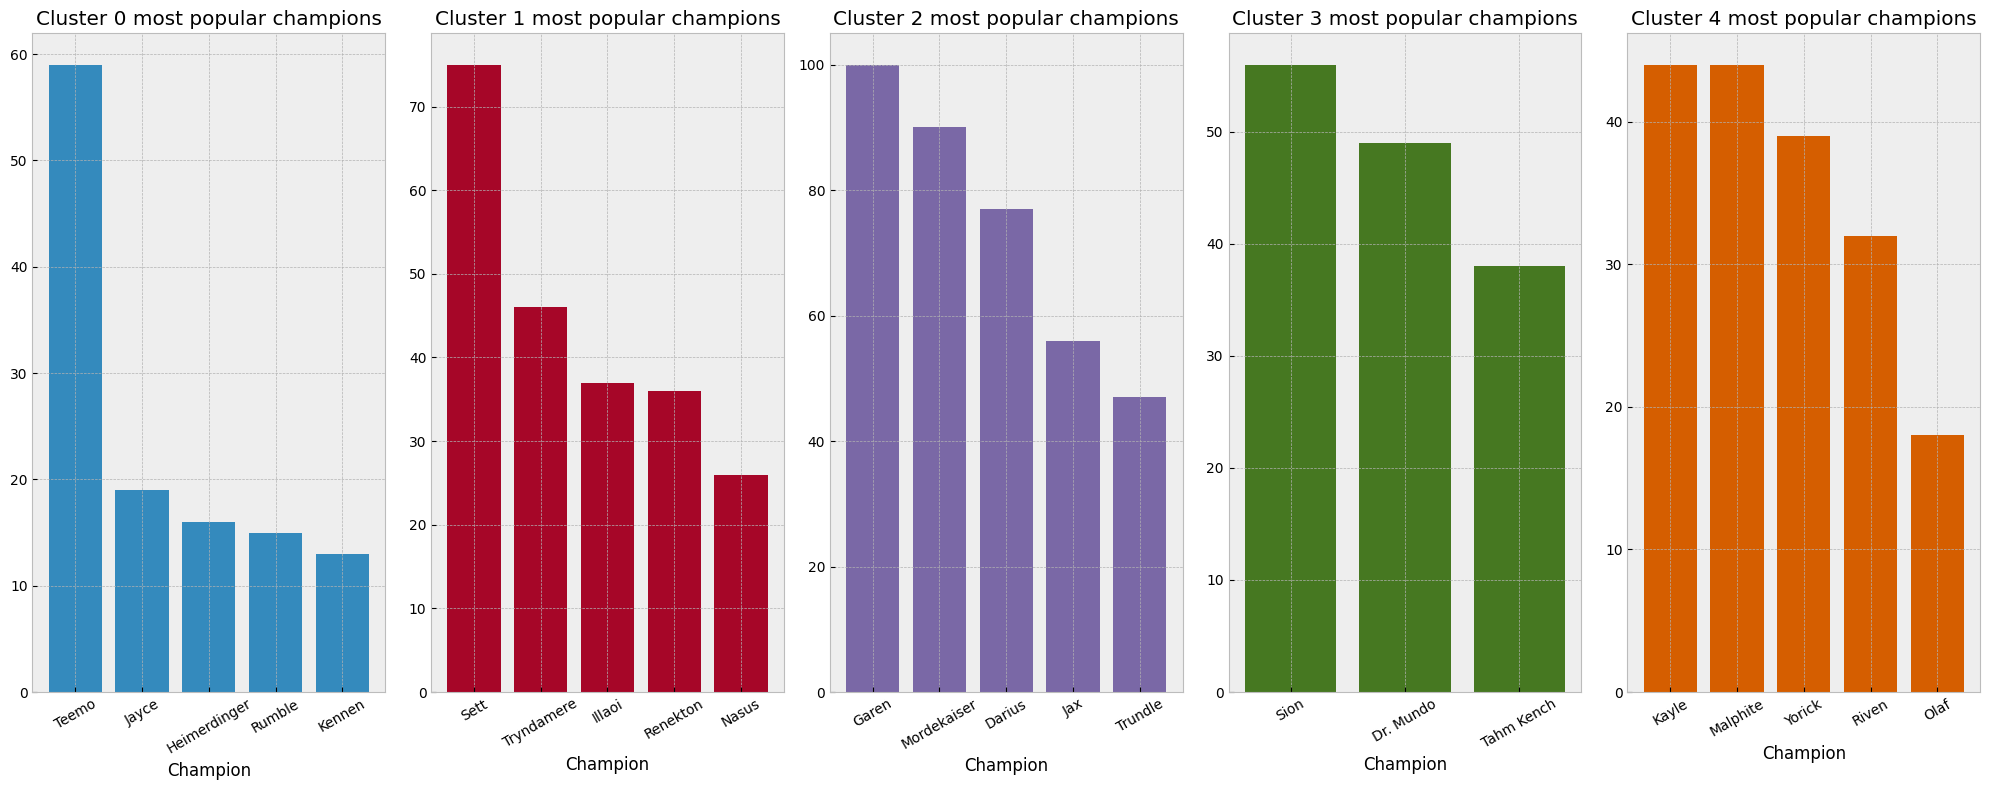

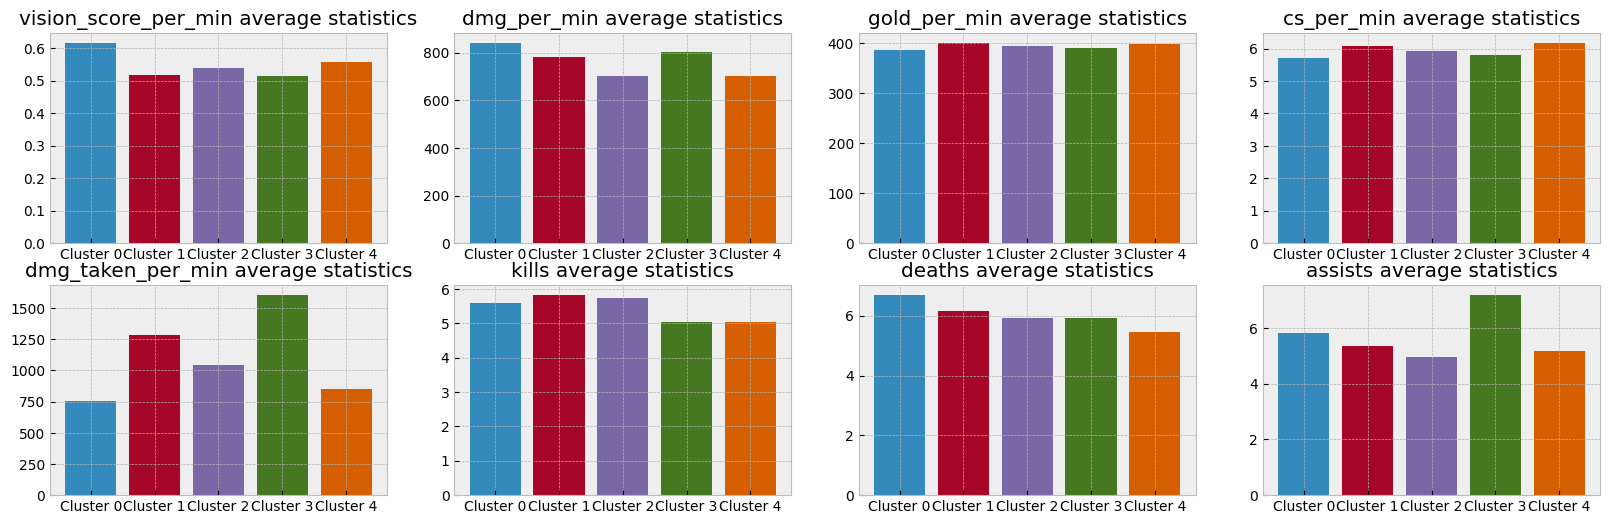

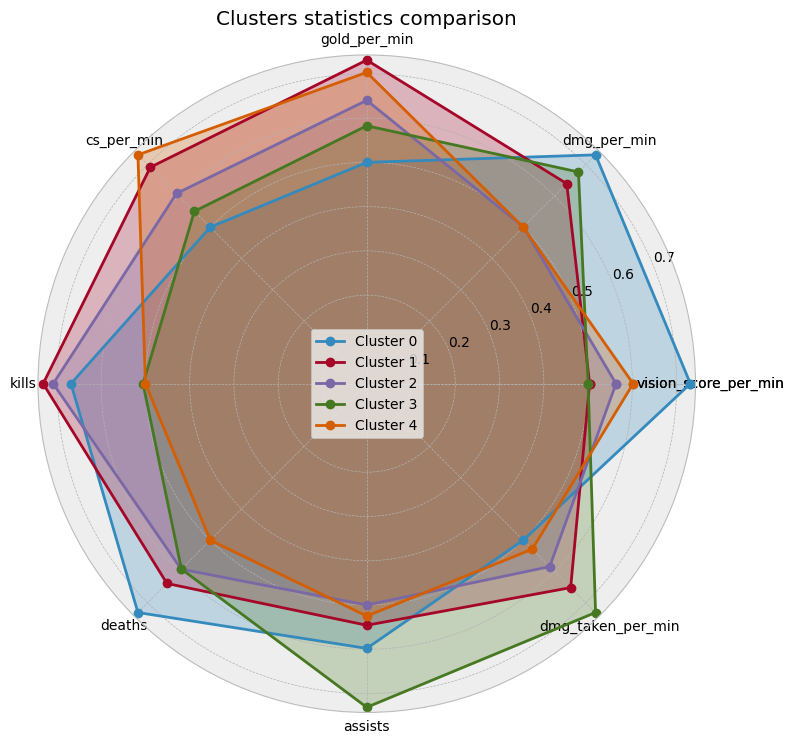

In [100]:
plot_clusters_by_lane('TOP', 5, data, champion_groups) 

Divided mostly by damage taken per minute
#### Conclusions:
- Cluster 0 - Range / high damage champions
- Cluster 1 and 3 - Mostly has bruisers, but the red cluster ones seem to have more dmg/min taken 
- Cluster 2 - Low 
- Cluster 4 - Tanks

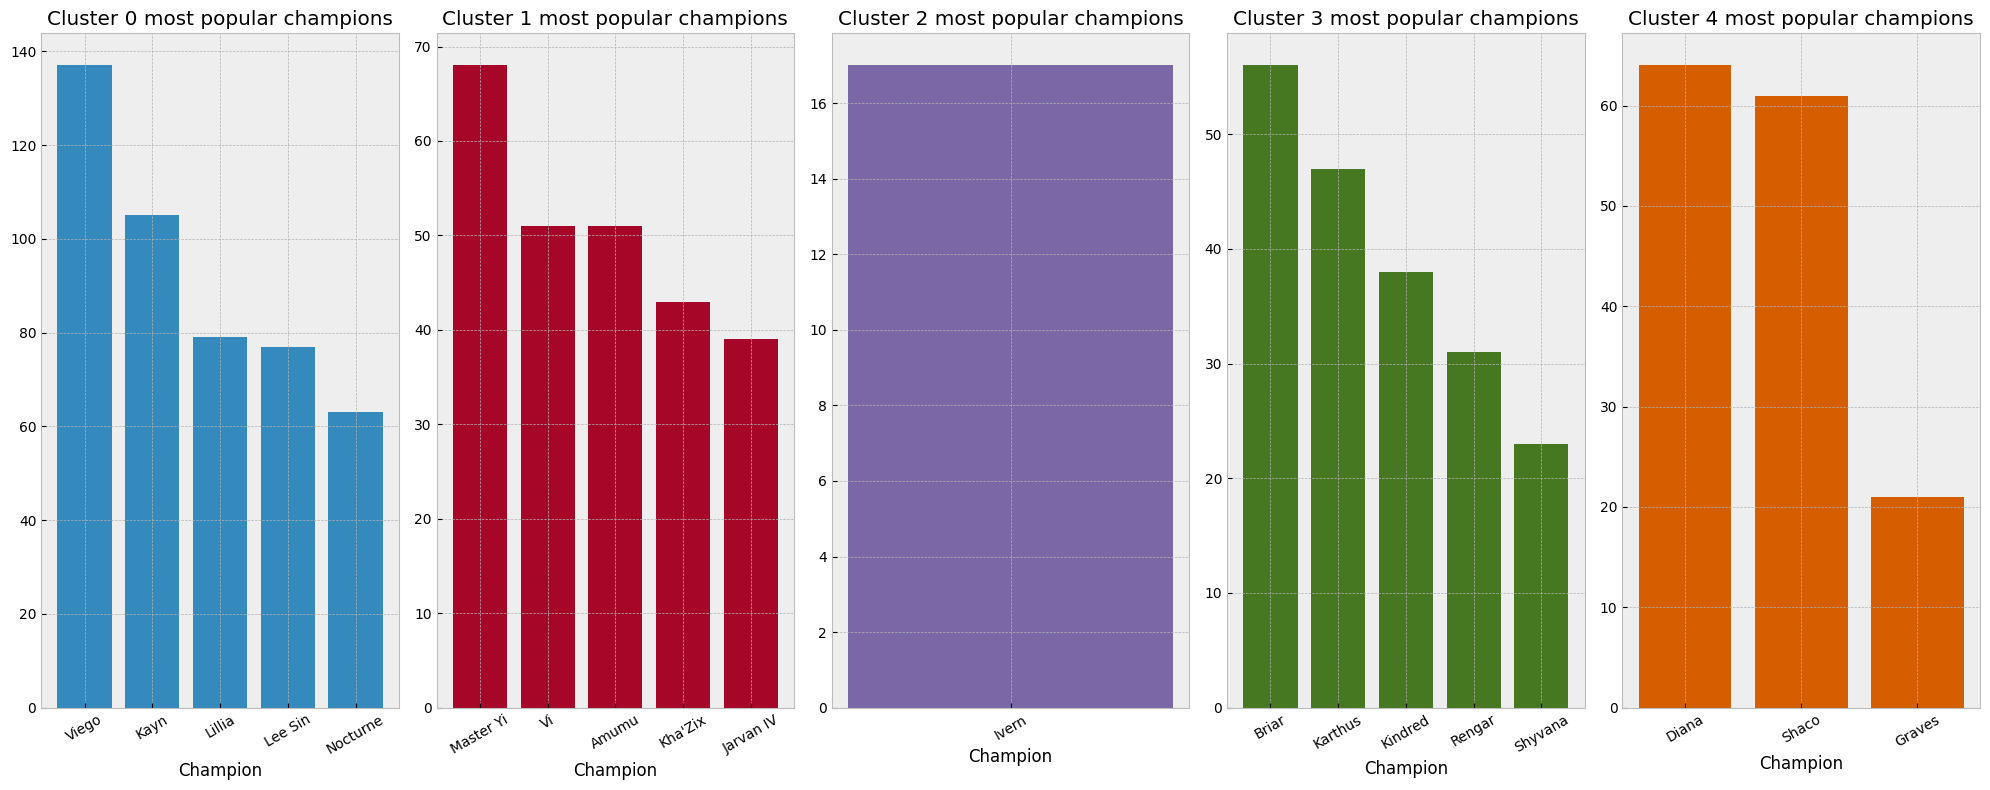

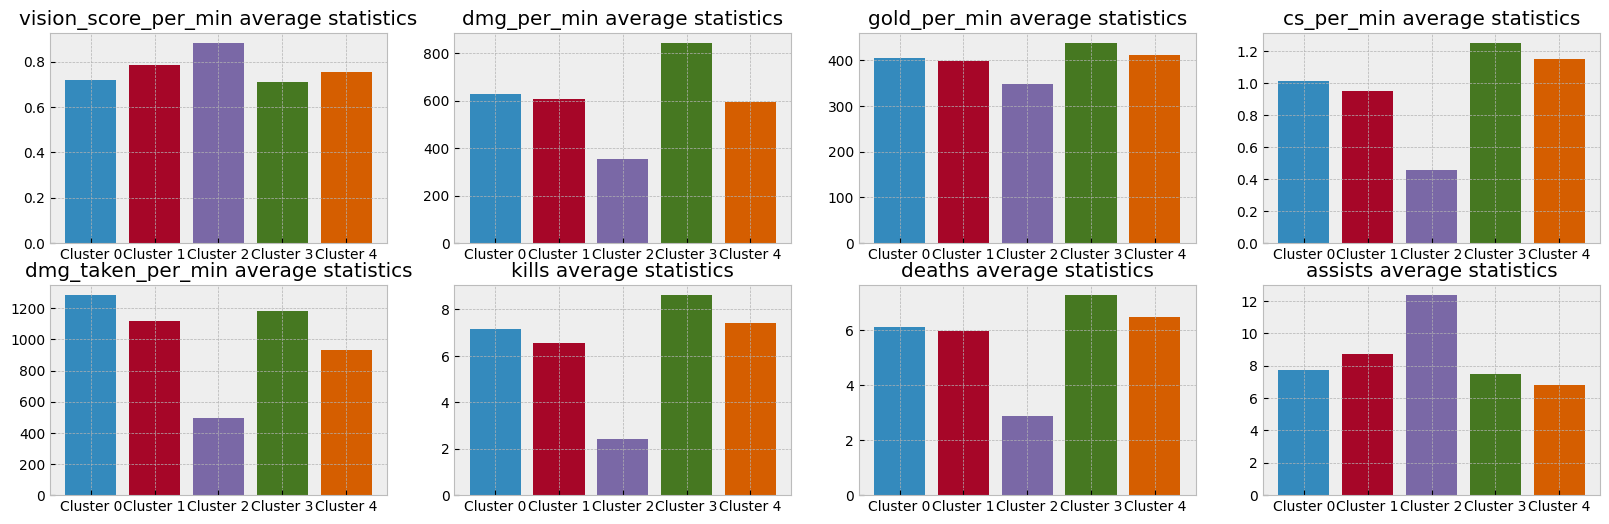

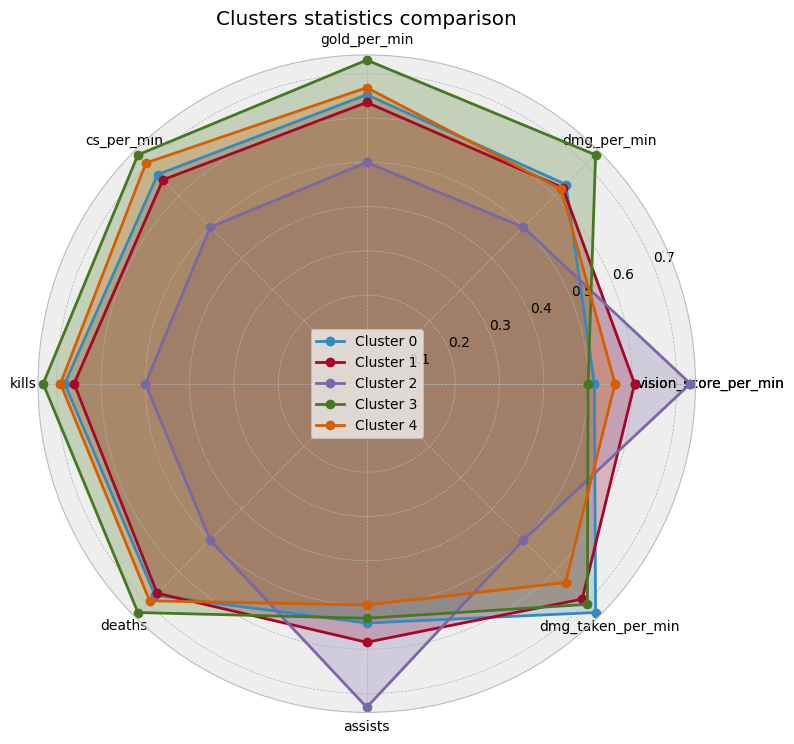

In [101]:
plot_clusters_by_lane('JNG', 5, data, champion_groups) 

#### Conclusions: 
Only conclusion I can make that clustering says that Ivern has a specific playstyle - its a jungle support, but other clusters are not informative. They are mostly divided by the amount of damage dealt and taken. Cluster 4 has frontline champions - they are grouped probably because of damage taken

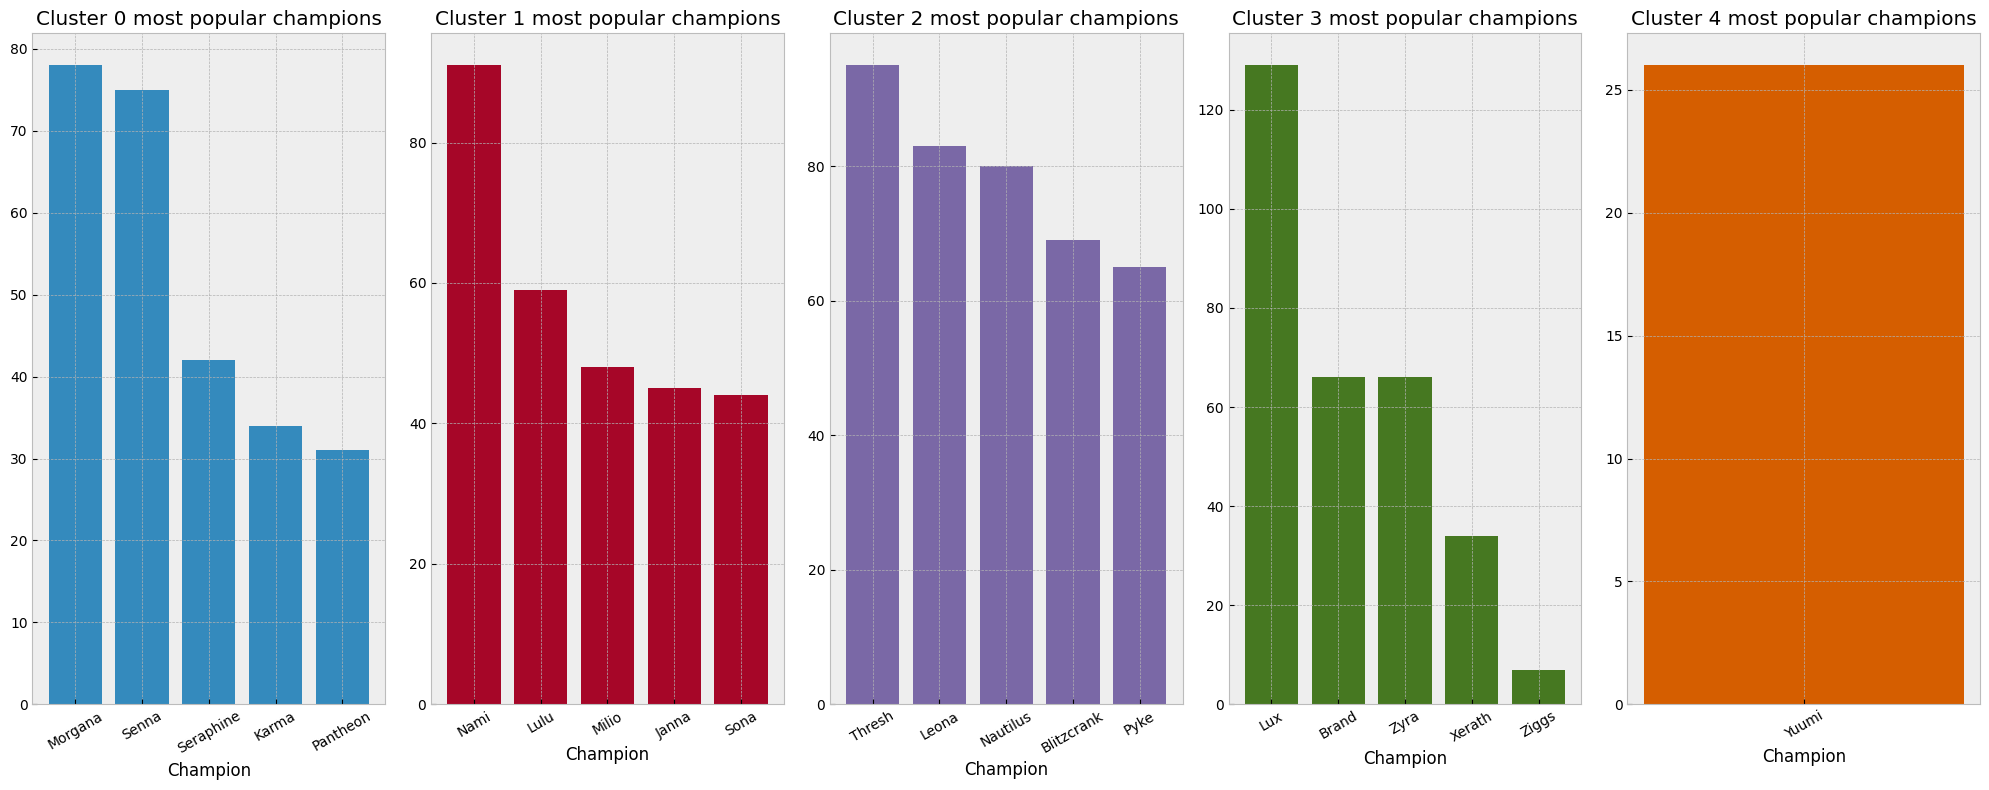

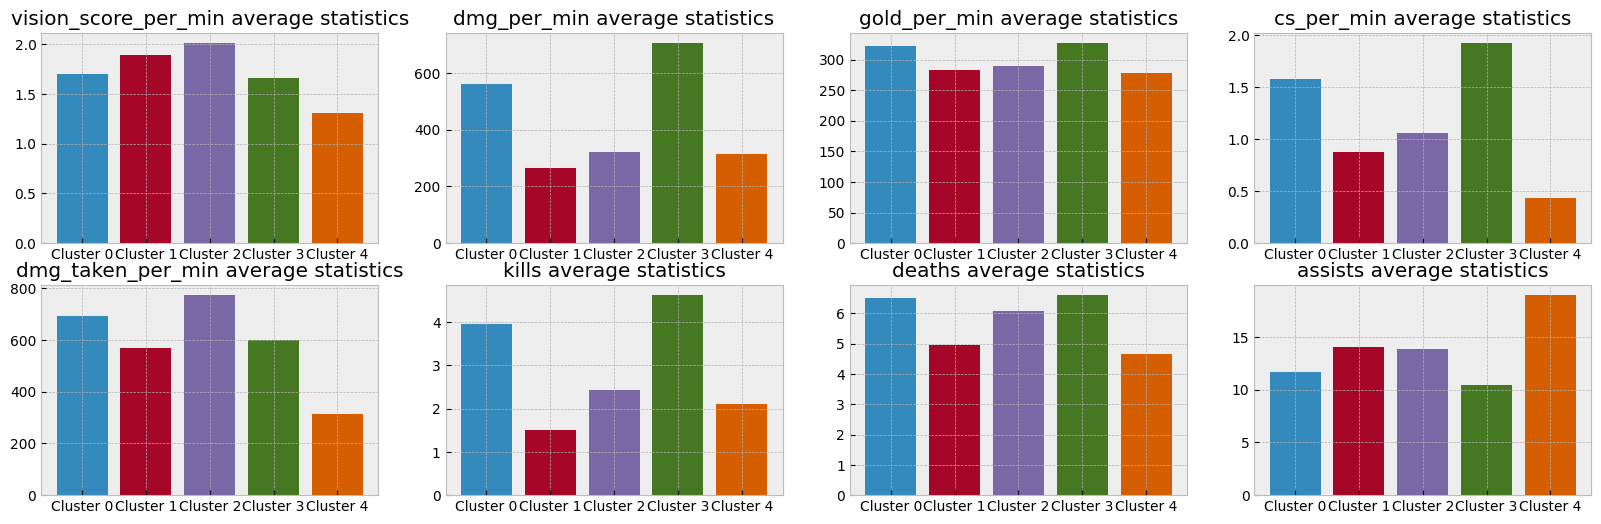

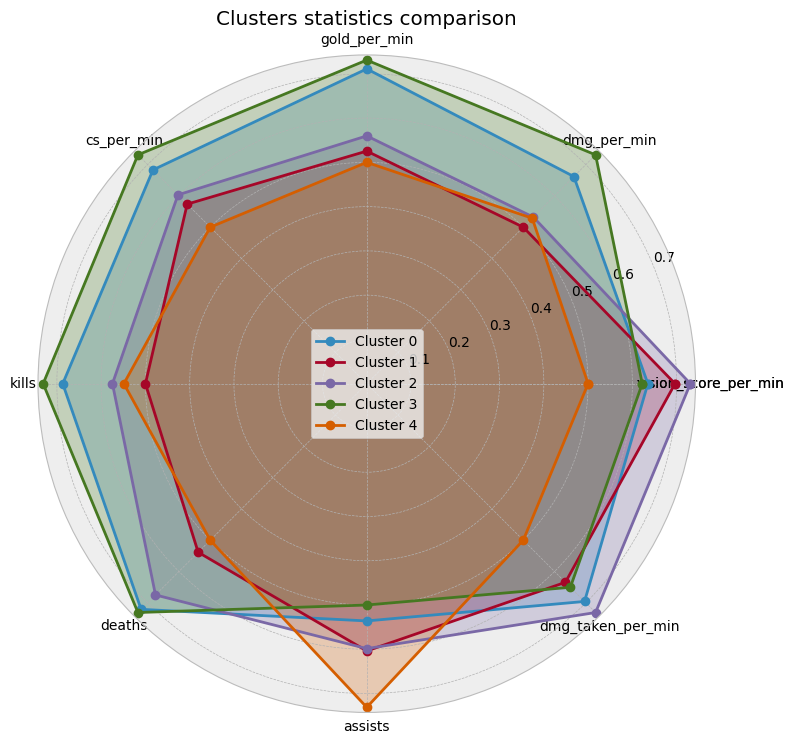

In [102]:
plot_clusters_by_lane('SUPP', 5, data, champion_groups) 

#### Conclusions:
- Cluster 0 - Damage supports
- Cluster 1 - Enchanter supports
- Cluster 2 - Tank supports
- Cluster 3 - Mage supports, simillar to cluster 0 but higher range - less damage taken, a bit more cs
- Cluster 4 - Yuumi - very specific playstyle - takes and deals very little damage 

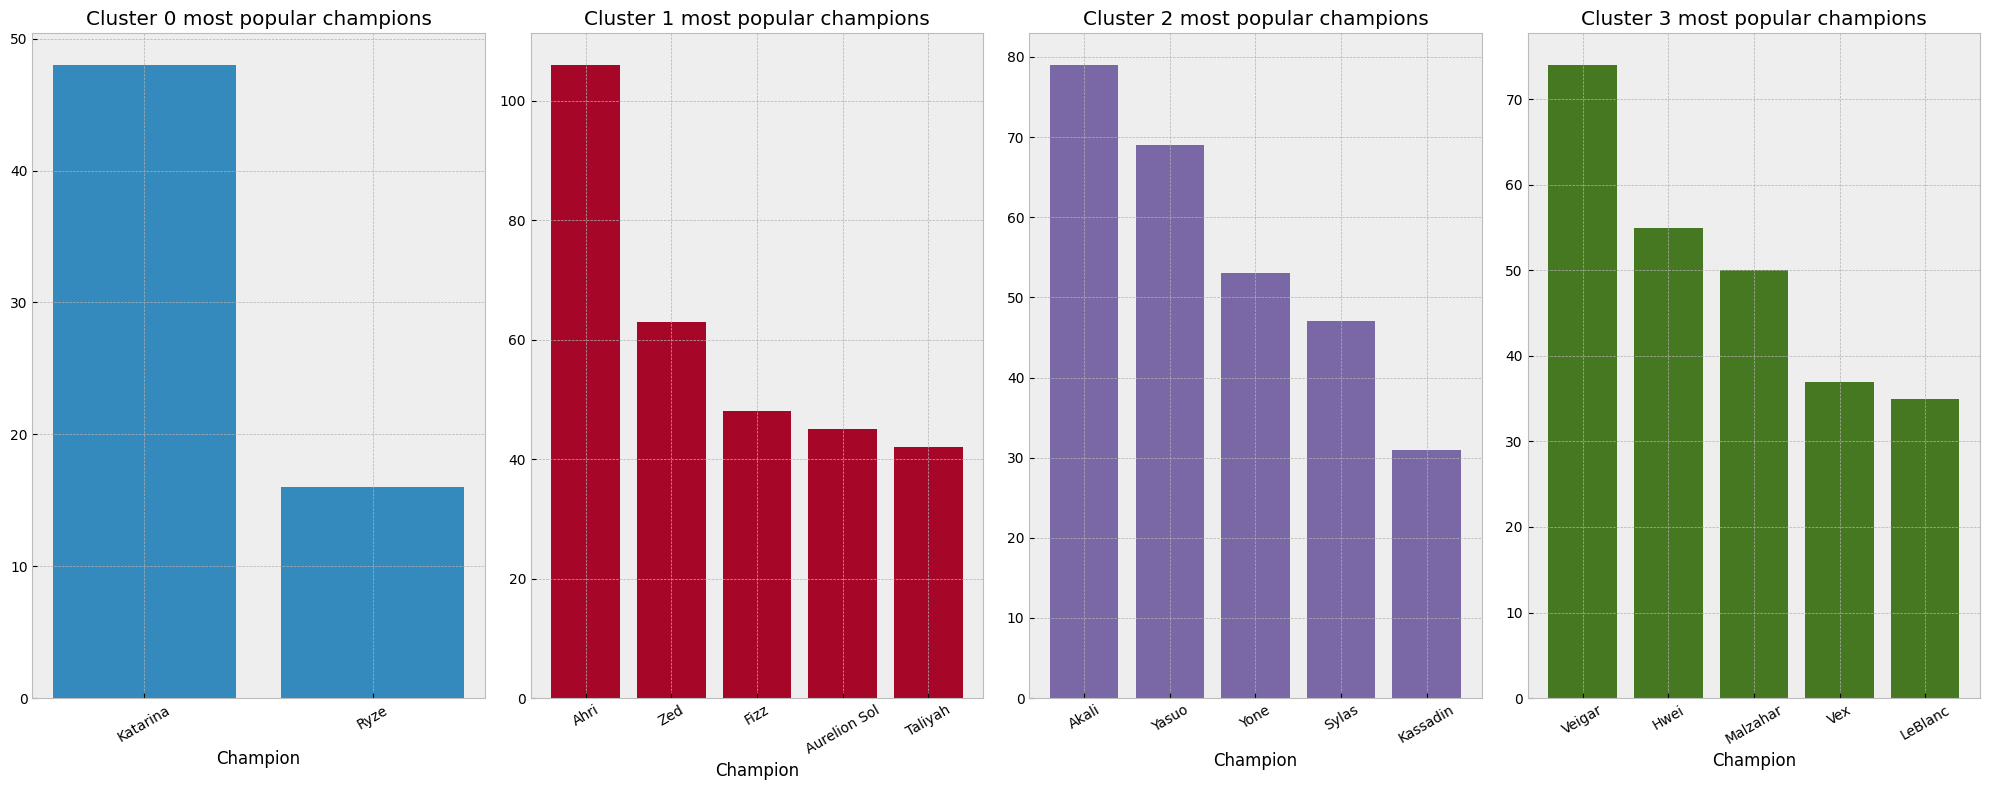

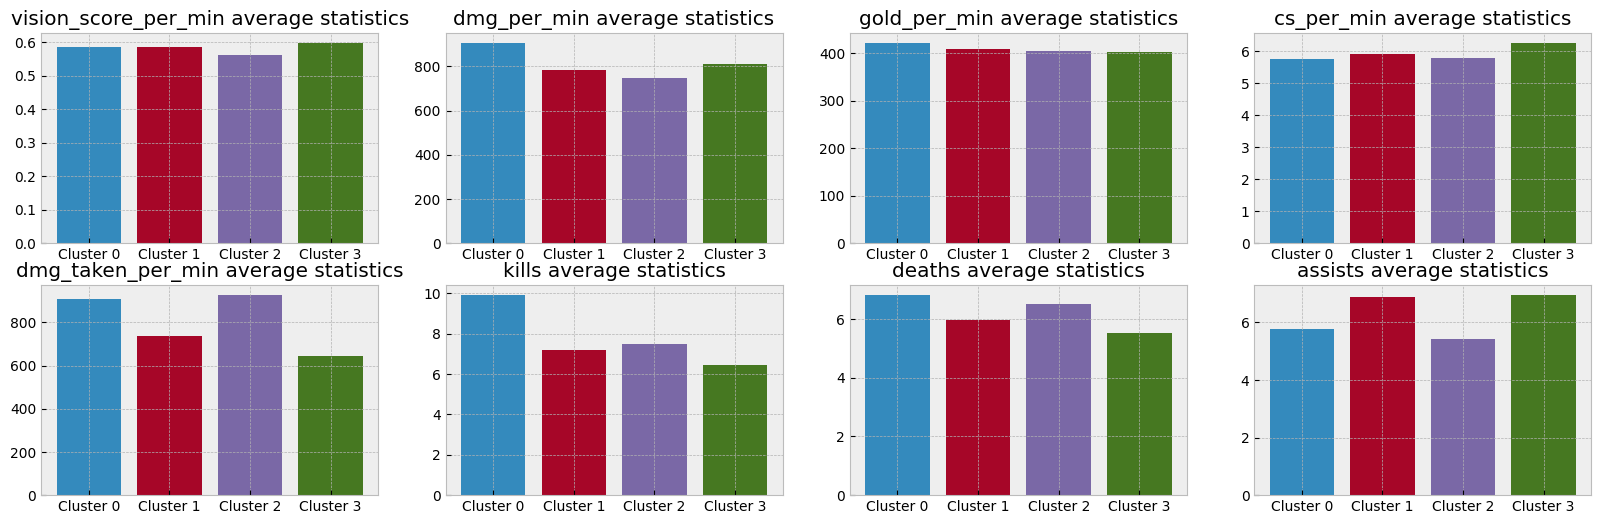

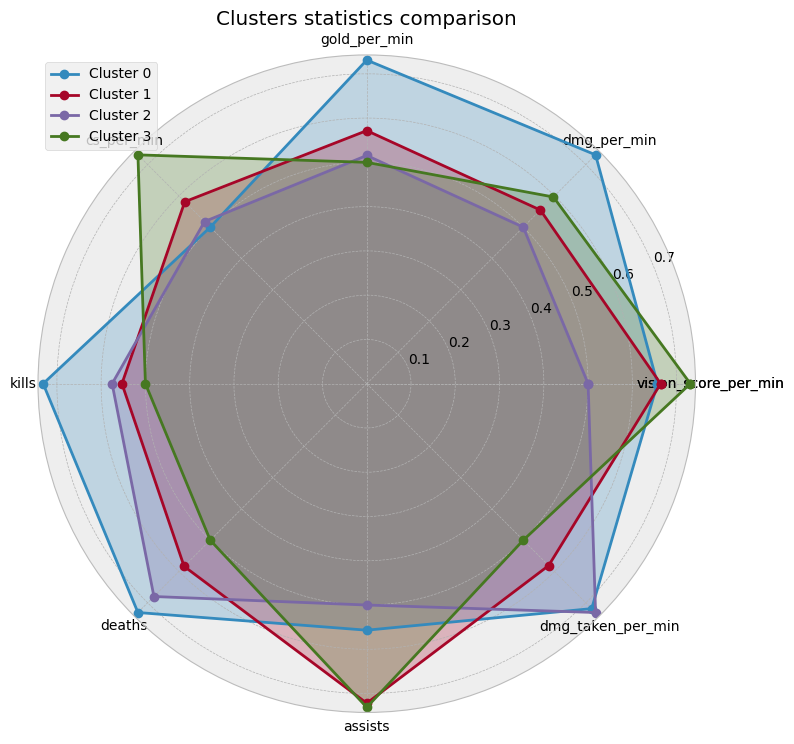

In [103]:
plot_clusters_by_lane('MID', 4, data, champion_groups)

#### Conclusions:
- Cluster 0 - Probably exists as these champions are played mostly by people who play them a lot an perform better overall because of more experience
- Cluster 1 - Does not group any specific group of champions
- Cluster 2 - Assasins
- Cluster 3 - Mages

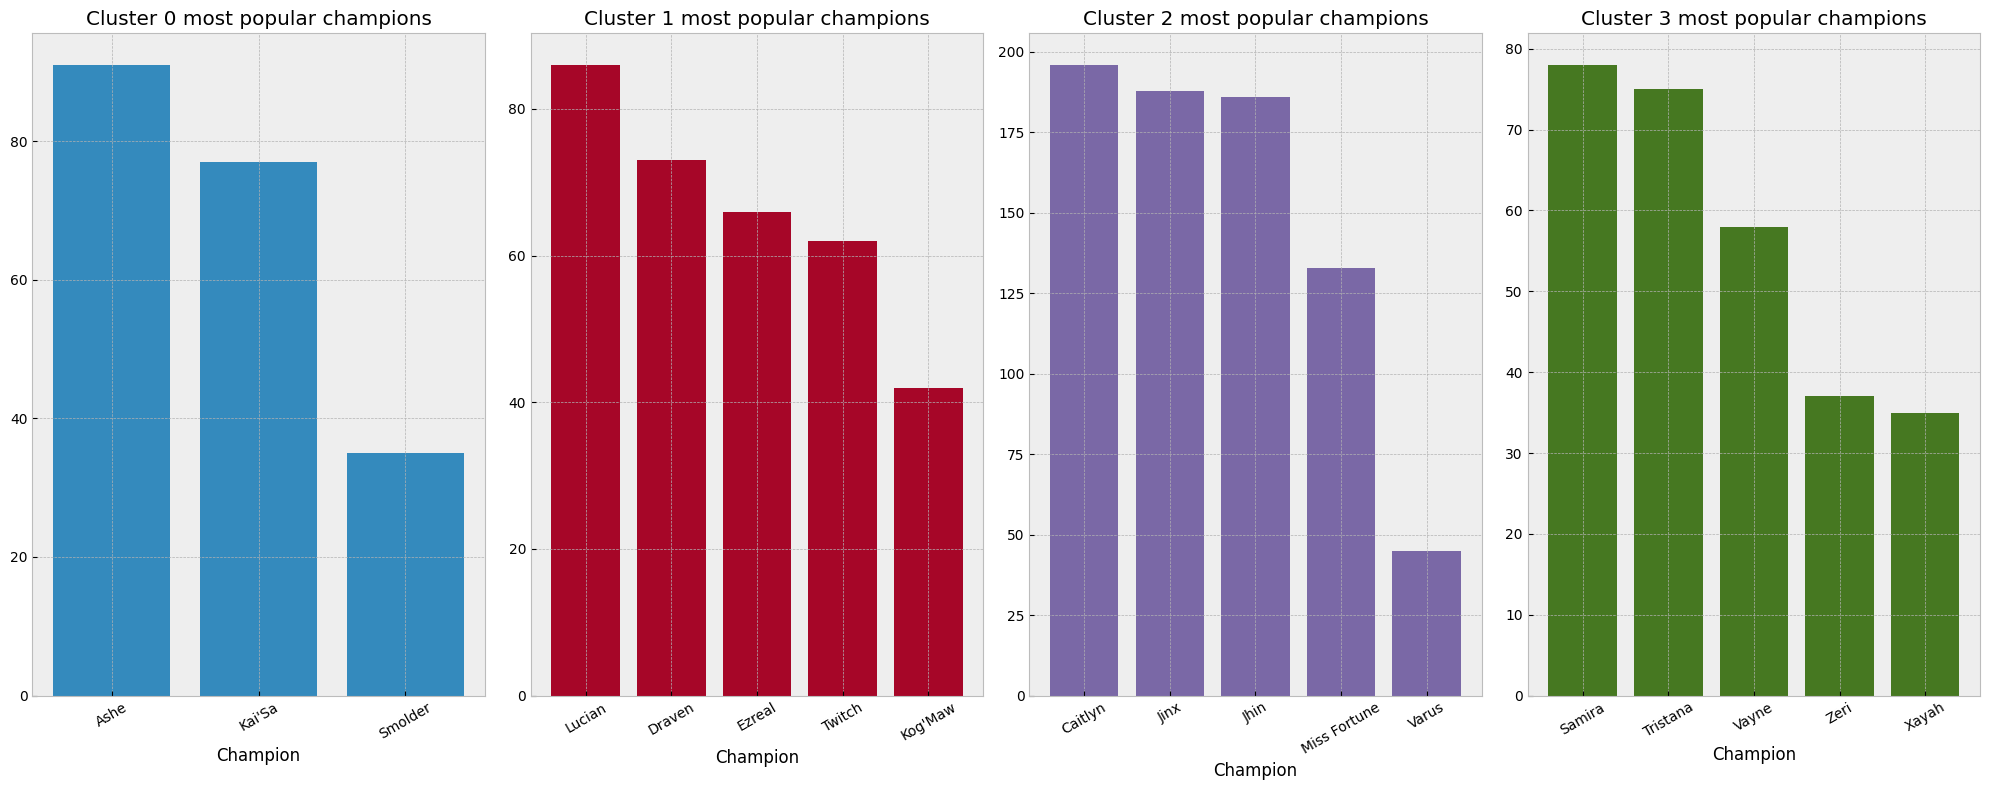

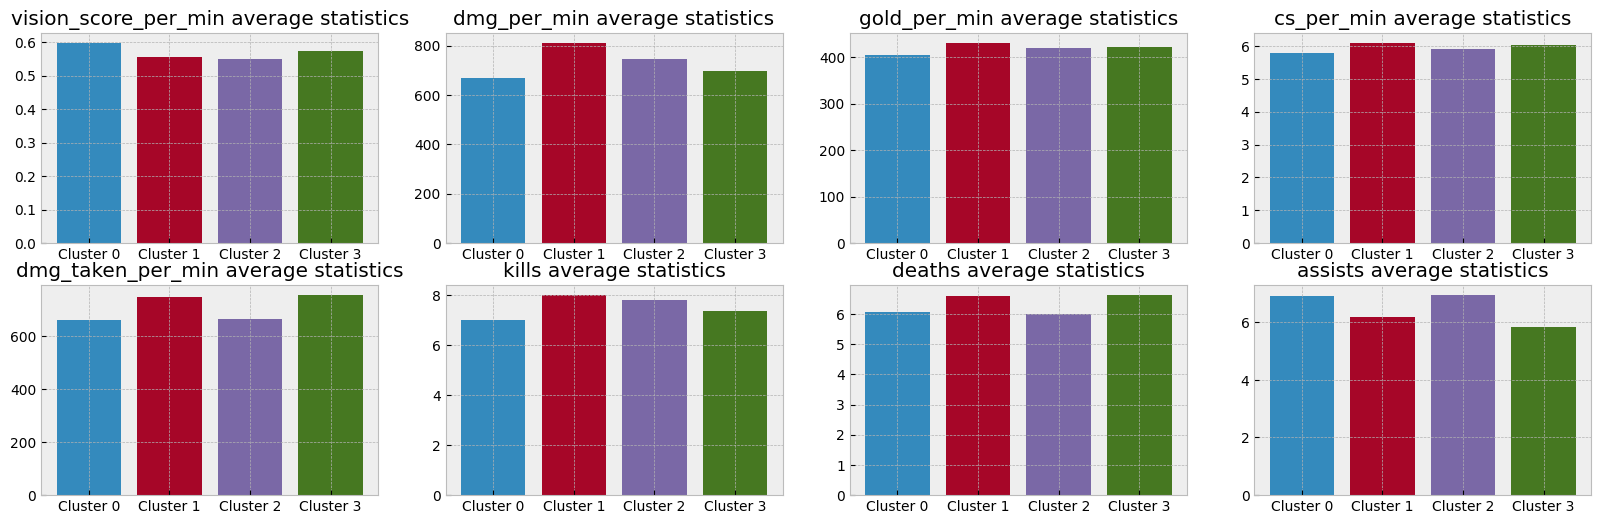

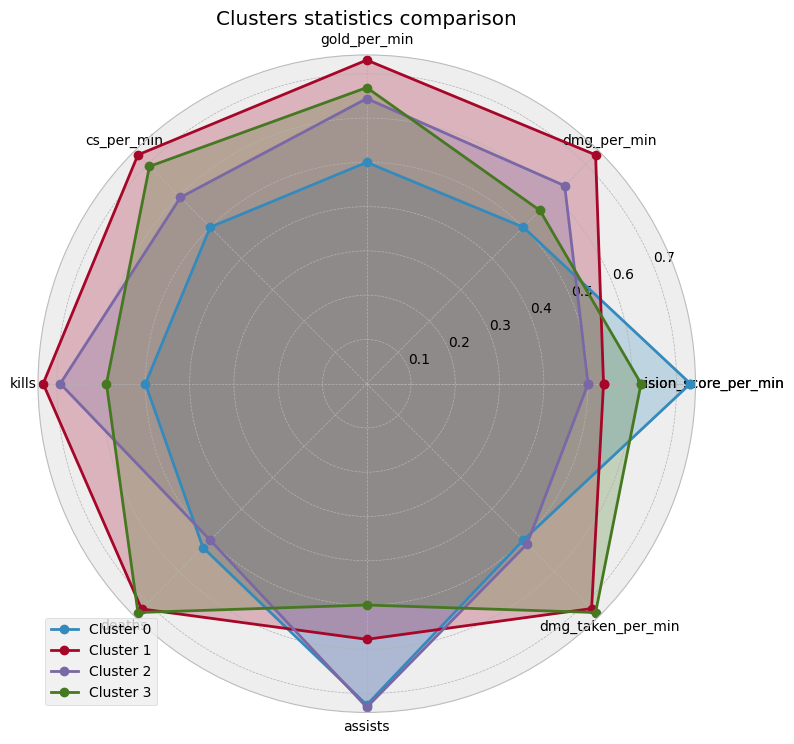

In [104]:
plot_clusters_by_lane('BOT', 4, data, champion_groups)

#### Conclusions:
It is hard to cluster champions in the BOT lane as all of them are marksmen and have similar playstyle.